# Mobility trends forecasting
## In this notebook we will implement a simple algorithm to forecast how mobility trends would have been if covid had not existed.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import requests
import itertools
import statsmodels.api as sm
from pylab import rcParams
from fbprophet import Prophet

## Let's start working with crime rates

In [3]:
municipal_crimes_df = pd.read_csv("Databases/IDM_NM_oct2020.csv", encoding="latin_1")
#Rename months so we can sort them properly
municipal_crimes_df.columns = ['Año', 'Clave_Ent', 'Entidad', 'Cve. Municipio', 'Municipio',
       'Bien jurídico afectado', 'Tipo de delito', 'Subtipo de delito',
       'Modalidad', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [4]:
municipal_crimes_df = municipal_crimes_df.set_index(['Año', 'Clave_Ent', 'Entidad', 'Cve. Municipio', 'Municipio',
       'Bien jurídico afectado', 'Tipo de delito', 'Subtipo de delito',
       'Modalidad']).stack().reset_index().rename(columns={'level_9': 'Mes', 0: 'No. de delitos'})

In [5]:
municipal_crimes_df.tail()

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Mes,No. de delitos
15675095,2020,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Otros delitos del Fuero Común,Otros delitos del Fuero Común,Otros delitos del Fuero Común,6,0.0
15675096,2020,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Otros delitos del Fuero Común,Otros delitos del Fuero Común,Otros delitos del Fuero Común,7,0.0
15675097,2020,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Otros delitos del Fuero Común,Otros delitos del Fuero Común,Otros delitos del Fuero Común,8,0.0
15675098,2020,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Otros delitos del Fuero Común,Otros delitos del Fuero Común,Otros delitos del Fuero Común,9,0.0
15675099,2020,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Otros delitos del Fuero Común,Otros delitos del Fuero Común,Otros delitos del Fuero Común,10,1.0


In [6]:
municipal_crimes_df['Tipo de delito'].unique()

array(['Homicidio', 'Lesiones', 'Feminicidio', 'Aborto',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Abuso sexual', 'Acoso sexual', 'Hostigamiento sexual',
       'Violación simple', 'Violación equiparada', 'Incesto',
       'Otros delitos que atentan contra la libertad y la seguridad sexual',
       'Robo', 'Fraude', 'Abuso de confianza', 'Extorsión',
       'Daño a la propiedad', 'Despojo',
       'Otros delitos contra el patrimonio', 'Violencia familiar',
       'Violencia de género en todas sus modalidades distinta a la violencia familiar',
       'Incumplimiento de obligaciones de asistencia familiar',
       'Otros delitos contra la familia', 'Corrupción de menores',
       'Trata de personas', 'Otros delitos contra la sociedad',
       'Narcomenudeo', 'Amenazas', 'Allanamiento de morada',
       'Evasión de presos', 'Falsedad'

In [7]:
municipal_crimes_df['Subtipo de delito'].unique()

array(['Homicidio doloso', 'Homicidio culposo', 'Lesiones dolosas',
       'Lesiones culposas', 'Feminicidio', 'Aborto',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Abuso sexual', 'Acoso sexual', 'Hostigamiento sexual',
       'Violación simple', 'Violación equiparada', 'Incesto',
       'Otros delitos que atentan contra la libertad y la seguridad sexual',
       'Robo a casa habitación', 'Robo de vehículo automotor',
       'Robo de autopartes', 'Robo a transportista',
       'Robo a transeúnte en vía pública',
       'Robo a transeúnte en espacio abierto al público',
       'Robo en transporte público individual',
       'Robo en transporte público colectivo',
       'Robo en transporte individual', 'Robo a institución bancaria',
       'Robo a negocio', 'Robo de ganado', 'Robo de maquinaria',
       'Otros robos', 'Fraude', 'Abuso

## Como primera prueba realicemos el analisis a nivel nacional

In [13]:
national_crimes_df = municipal_crimes_df[['Año', 'Mes', 'No. de delitos']].groupby(['Año', 'Mes']).sum().reset_index()

national_crimes_df['DateTime'] = national_crimes_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']), 
                 day = 1)), axis=1)

national_crimes_df.drop(columns = ['Año', 'Mes'], inplace=True)

In [14]:
national_crimes_change = national_crimes_df.set_index('DateTime')['2019-11':]
national_crimes_change['Cambio porcentual mensual'] = national_crimes_change['No. de delitos'].pct_change()*100
national_crimes_change.drop(columns='No. de delitos')

,Cambio porcentual mensual
DateTime,
2019-11-01,NaN
2019-12-01,-3.893248
2020-01-01,4.777102
2020-02-01,1.094739
2020-03-01,2.251086
2020-04-01,-30.094351
2020-05-01,1.718626
2020-06-01,16.333782
2020-07-01,8.704301


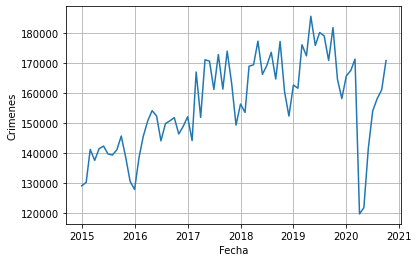

In [10]:
plt.plot(national_crimes_df.set_index('DateTime'))
plt.xlabel('Fecha')
plt.ylabel('Crimenes')
plt.grid()

## We need to split the dataframe in the data before and after COVID19
The pandemic started in mexico in march

In [11]:
national_crimes_before_covid_df = national_crimes_df.where(national_crimes_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')
national_crimes_after_covid_df = national_crimes_df.where(national_crimes_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

In [12]:
national_crimes_after_covid_df.index

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', name='DateTime', freq=None)

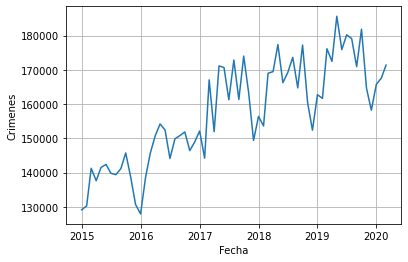

In [13]:
plt.plot(national_crimes_before_covid_df)
plt.xlabel('Fecha')
plt.ylabel('Crimenes')
plt.grid()

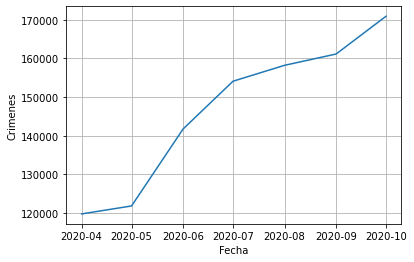

In [14]:
plt.plot(national_crimes_after_covid_df)
plt.xlabel('Fecha')
plt.ylabel('Crimenes')
plt.grid()

Let's see the decomposition of the national crimes taking covid into consideration.

There is a clear decline in the trend, this means that the pandemic had a strong impact in diminishing the total amount of crimes. 

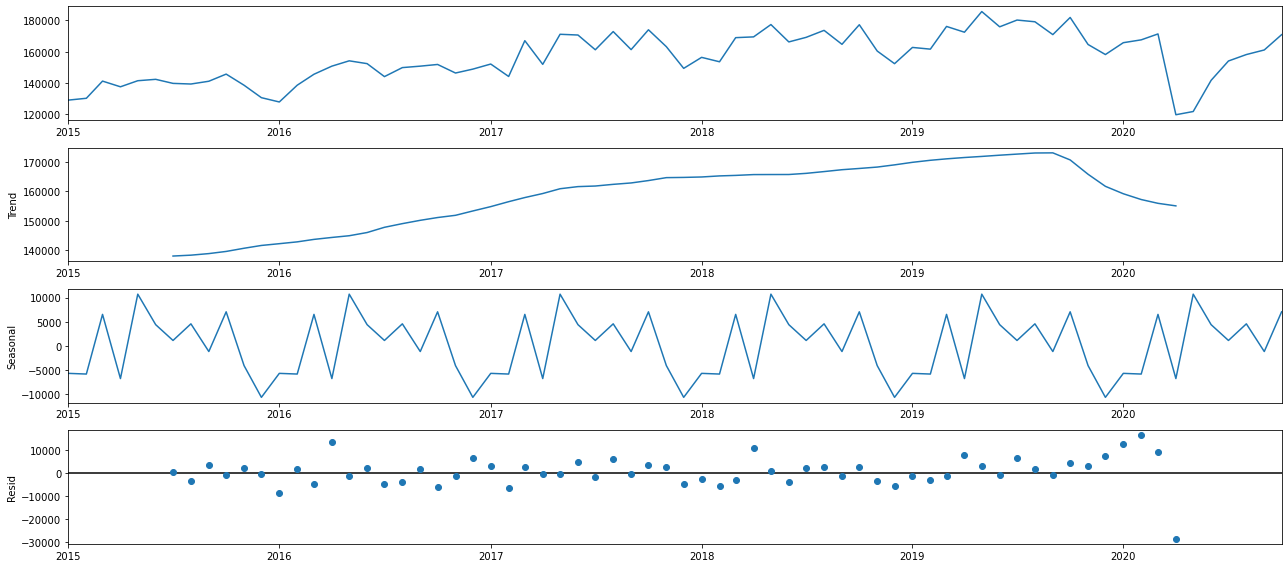

In [15]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_crimes_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

If we take into account only the crimes before covid, the trend is positive and considerably constant. We will make use of this data to predict how the trend would have been if the pandemic had not ocurred.

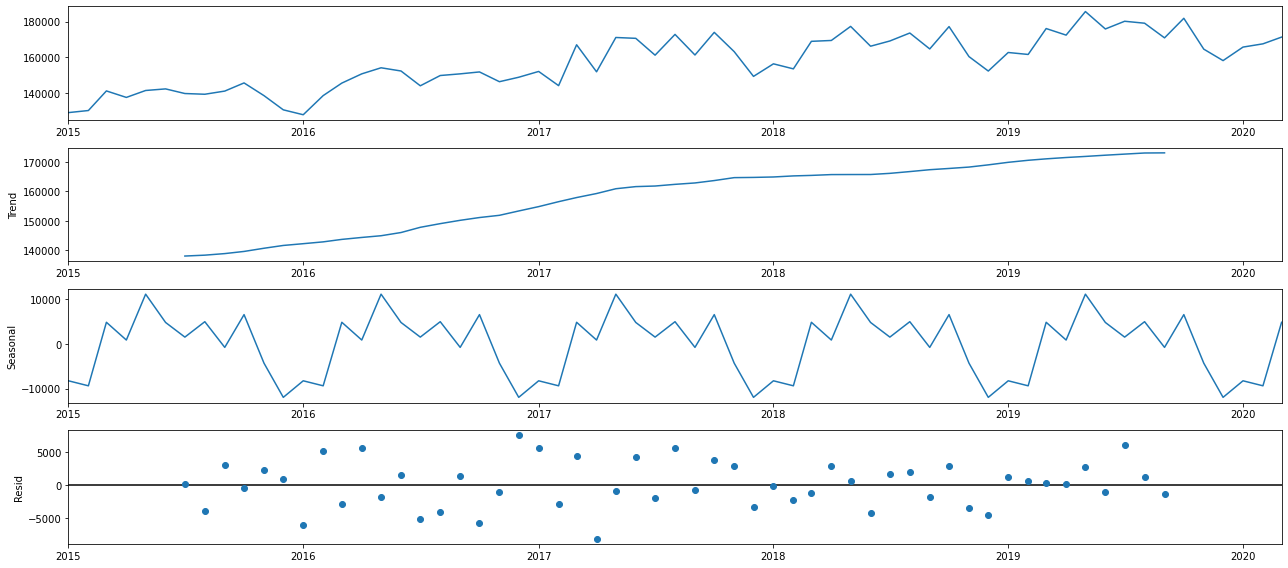

In [16]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_crimes_before_covid_df, model='additive')
fig = decomposition.plot()
plt.show()

## Let's use ARIMA as the time series forecaster

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
params_values = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(national_crimes_before_covid_df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False);
            results = mod.fit()
            params_values.append([param, param_seasonal, results.aic])
        except:
            continue

/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMT

In [19]:
pd.DataFrame(params_values).sort_values(2)

,0,1,2
31,"(0, 1, 1)","(1, 1, 1, 12)",735.454724
59,"(1, 1, 1)","(0, 1, 1, 12)",735.768205
27,"(0, 1, 1)","(0, 1, 1, 12)",743.230023
63,"(1, 1, 1)","(1, 1, 1, 12)",746.142114
62,"(1, 1, 1)","(1, 1, 0, 12)",750.702875
...,...,...,...
32,"(1, 0, 0)","(0, 0, 0, 12)",1308.256678
1,"(0, 0, 0)","(0, 0, 1, 12)",1315.207029
12,"(0, 0, 1)","(1, 0, 0, 12)",1321.904754
8,"(0, 0, 1)","(0, 0, 0, 12)",1594.960318


In [20]:
mod = sm.tsa.statespace.SARIMAX(national_crimes_before_covid_df,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5705      0.138     -4.127      0.000      -0.841      -0.300
ar.S.L12      -0.4183      0.480     -0.871      0.384      -1.359       0.523
ma.S.L12       0.0617      0.554      0.111      0.911      -1.025       1.148
sigma2      4.522e+07   1.77e-09   2.56e+16      0.000    4.52e+07    4.52e+07


/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/ernesto/anaconda3/envs/EMTech/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


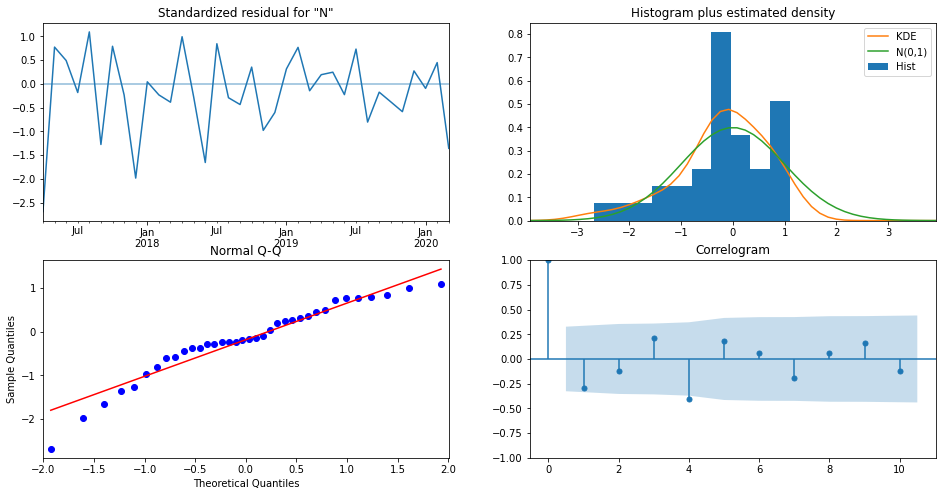

In [21]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), end=pd.to_datetime('2020-10-01'), dynamic=False)
pred_ci = pred.conf_int()

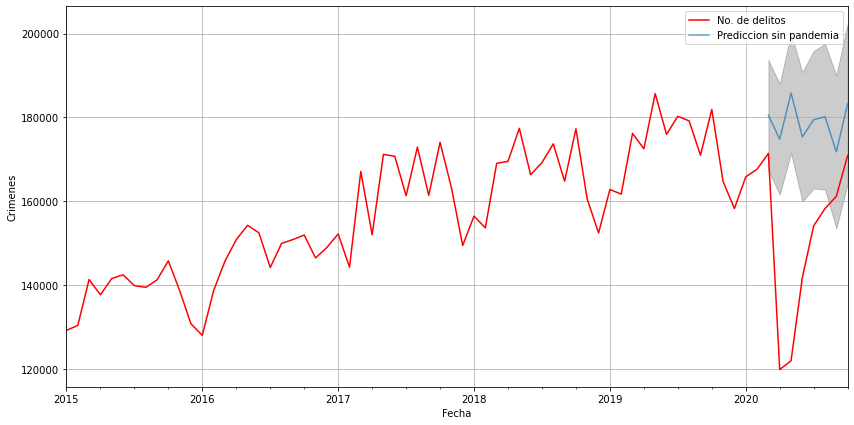

In [23]:
ax = national_crimes_df.set_index('DateTime').plot(label='observed', color='r')
pred.predicted_mean.plot(ax=ax, label='Prediccion sin pandemia', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Crimenes')
plt.legend()
plt.grid()
plt.show()

## Let's use FBProphet to predict this data

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


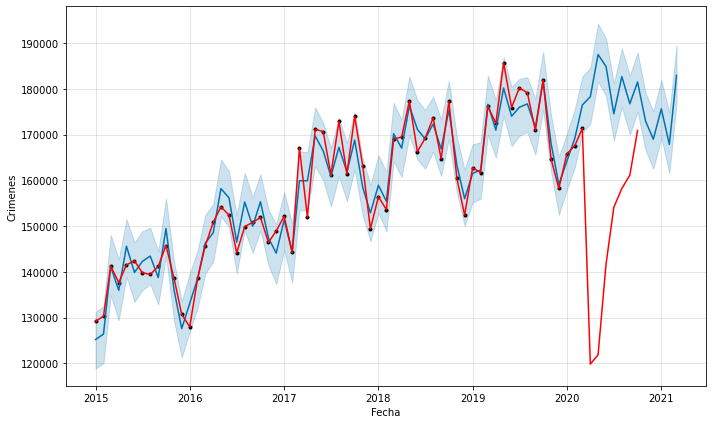

In [24]:
nat_crimes_before_cov_df_renamed = national_crimes_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de delitos': 'y'})
national_crimes_model = Prophet(interval_width=0.95)
national_crimes_model.fit(nat_crimes_before_cov_df_renamed)

national_crimes_forecast = national_crimes_model.make_future_dataframe(periods=12, freq='MS')
national_crimes_forecast = national_crimes_model.predict(national_crimes_forecast)

national_crimes_model.plot(national_crimes_forecast, xlabel = 'Fecha', ylabel = 'Crimenes')
plt.plot(national_crimes_df.set_index('DateTime'), color='r')

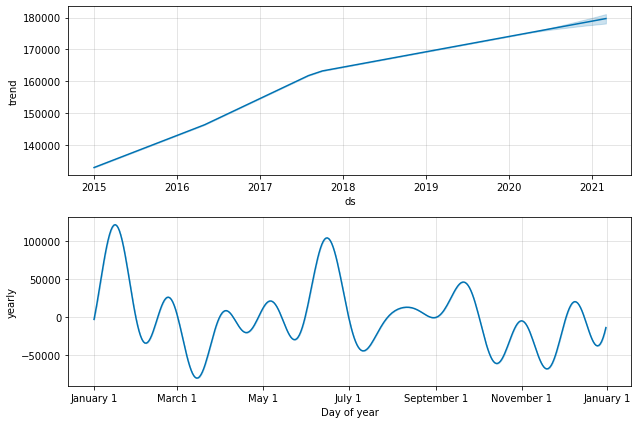

In [25]:
fig2 = national_crimes_model.plot_components(national_crimes_forecast)

## Let's repeat all over again, but splitting in gender and sexual crimes vs robbery and see the trends

In [6]:
sex_and_gender_crimes = ['Feminicidio', 'Aborto',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Abuso sexual', 'Acoso sexual', 'Hostigamiento sexual',
       'Violación simple', 'Violación equiparada', 'Incesto',
       'Otros delitos que atentan contra la libertad y la seguridad sexual', 
        'Violencia familiar',
       'Violencia de género en todas sus modalidades distinta a la violencia familiar',
       'Otros delitos contra la familia']

In [7]:
robbery_crimes = ['Robo a casa habitación', 'Robo de vehículo automotor',
       'Robo de autopartes', 'Robo a transportista',
       'Robo a transeúnte en vía pública',
       'Robo a transeúnte en espacio abierto al público',
       'Robo en transporte público individual',
       'Robo en transporte público colectivo',
       'Robo en transporte individual', 'Robo a institución bancaria',
       'Robo a negocio', 'Robo de ganado', 'Robo de maquinaria',
       'Otros robos', 'Fraude', 'Abuso de confianza', 'Extorsión', 'Despojo', 'Allanamiento de morada']

In [8]:
municipal_sex_gender_crimes_df = municipal_crimes_df.where(municipal_crimes_df['Subtipo de delito'].isin(sex_and_gender_crimes)).dropna()

In [9]:
municipal_robbery_crimes_df = municipal_crimes_df.where(municipal_crimes_df['Subtipo de delito'].isin(robbery_crimes)).dropna()

In [10]:
national_sex_gender_crimes_df = municipal_sex_gender_crimes_df[['Año', 'Mes', 'No. de delitos']].groupby(['Año', 'Mes']).sum().reset_index()

national_sex_gender_crimes_df['DateTime'] = national_sex_gender_crimes_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']), 
                 day = 1)), axis=1)

national_sex_gender_crimes_df.drop(columns = ['Año', 'Mes'], inplace=True)

In [11]:
national_robbery_df = municipal_robbery_crimes_df[['Año', 'Mes', 'No. de delitos']].groupby(['Año', 'Mes']).sum().reset_index()

national_robbery_df['DateTime'] = national_robbery_df.apply(lambda entry: pd.to_datetime(
    pd.Timestamp(year = int(entry['Año']), month = int(entry['Mes']), 
                 day = 1)), axis=1)

national_robbery_df.drop(columns = ['Año', 'Mes'], inplace=True)

## Let's find the proportion of crimes in 2020

In [15]:
total_crimes = national_crimes_df.set_index('DateTime')['2020'].sum()
sex_gender_crimes = national_sex_gender_crimes_df.set_index('DateTime')['2020'].sum()
robbery_crimes = national_robbery_df.set_index('DateTime')['2020'].sum()

sex_gender_crimes/total_crimes, robbery_crimes/total_crimes

(No. de delitos    0.165654
 dtype: float64,
 No. de delitos    0.408992
 dtype: float64)

## Let's explore the percentual change in sex and gender crimes through 2020

In [21]:
national_sex_gender_crimes_change = national_sex_gender_crimes_df.set_index('DateTime')['2019-11':]
national_sex_gender_crimes_change['Cambio porcentual mensual'] = national_sex_gender_crimes_change['No. de delitos'].pct_change()*100
national_sex_gender_crimes_change.drop(columns='No. de delitos')

,Cambio porcentual mensual
DateTime,
2019-11-01,NaN
2019-12-01,-0.958452
2020-01-01,0.643630
2020-02-01,14.618106
2020-03-01,14.186221
2020-04-01,-29.013030
2020-05-01,6.341535
2020-06-01,16.646008
2020-07-01,4.620410


## There seems to be a major decrease in march, is it due to covid or to the regular seasonality. Let's do the same for the previous year

In [26]:
national_sex_gender_crimes_change = national_sex_gender_crimes_df.set_index('DateTime')['2018-11':'2019']
national_sex_gender_crimes_change['Cambio porcentual mensual'] = national_sex_gender_crimes_change['No. de delitos'].pct_change()*100
national_sex_gender_crimes_change.drop(columns='No. de delitos')

,Cambio porcentual mensual
DateTime,
2018-11-01,NaN
2018-12-01,-8.223104
2019-01-01,15.085275
2019-02-01,9.350866
2019-03-01,11.595724
2019-04-01,2.706748
2019-05-01,14.380282
2019-06-01,-6.169694
2019-07-01,0.853441


## Now let's do the same with the robbery related crimes

In [22]:
national_robbery_change = national_robbery_df.set_index('DateTime')['2019-11':]
national_robbery_change['Cambio porcentual mensual'] = national_robbery_change['No. de delitos'].pct_change()*100
national_robbery_change.drop(columns='No. de delitos')

,Cambio porcentual mensual
DateTime,
2019-11-01,NaN
2019-12-01,-5.726962
2020-01-01,7.281153
2020-02-01,-5.632871
2020-03-01,-2.021170
2020-04-01,-28.332628
2020-05-01,1.419841
2020-06-01,13.362926
2020-07-01,11.945429


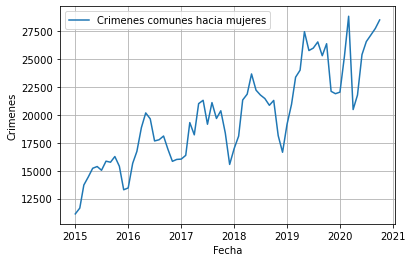

In [18]:
plt.plot(national_sex_gender_crimes_df.set_index('DateTime'), label='Crimenes comunes hacia mujeres')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Crimenes')
plt.grid()
plt.show()

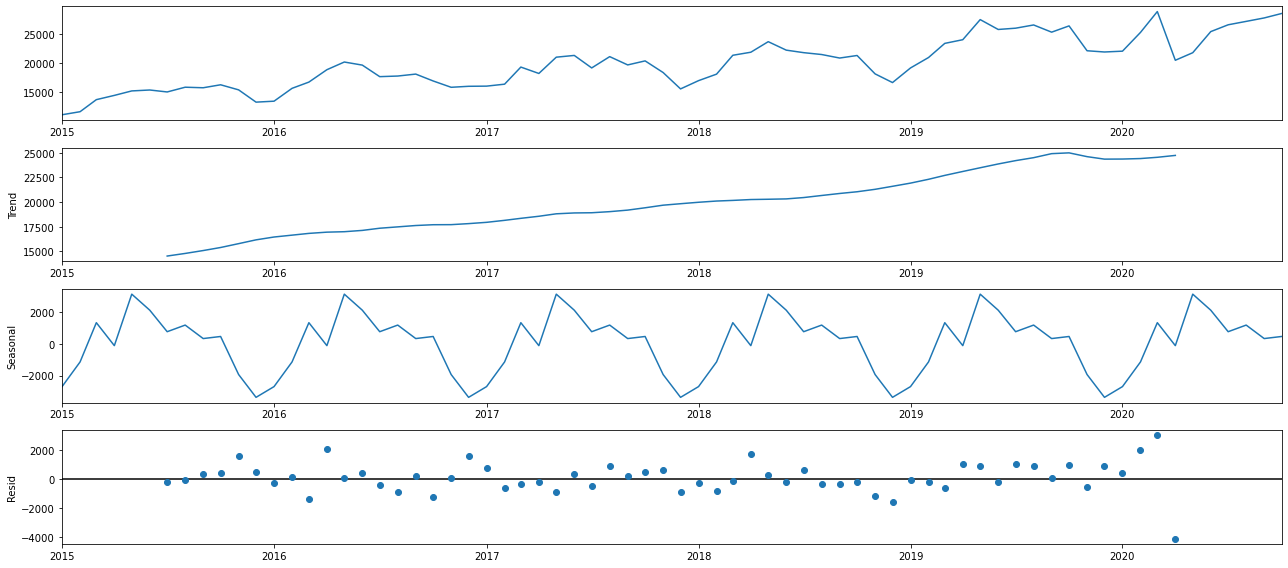

In [19]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_sex_gender_crimes_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

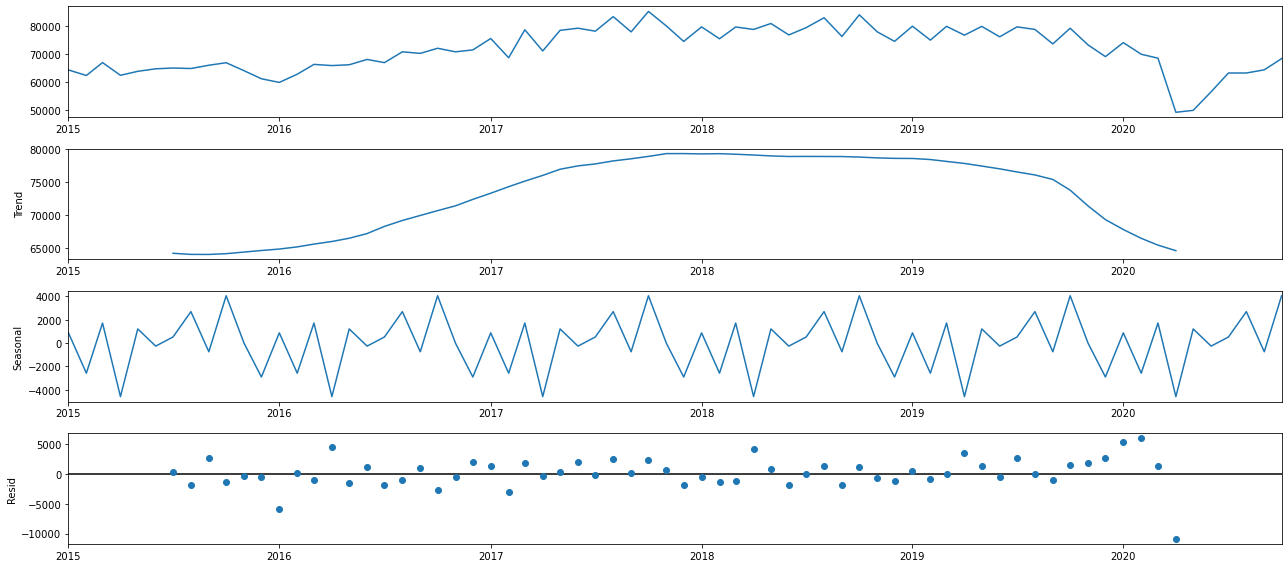

In [20]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(national_robbery_df.set_index('DateTime'), model='additive')
fig = decomposition.plot()
plt.show()

## Let's split both dataframes in before and after covid19

In [ ]:
national_sex_gender_crimes_before_covid_df = national_sex_gender_crimes_df.where(
    national_sex_gender_crimes_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

national_sex_gender_crimes_after_covid_df = national_sex_gender_crimes_df.where(
    national_sex_gender_crimes_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

In [ ]:
national_robbery_crimes_before_covid_df = national_robbery_df.where(
    national_robbery_df['DateTime'] < pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

national_robbery_crimes_after_covid_df = national_robbery_df.where(
    national_robbery_df['DateTime'] > pd.Timestamp(2020,3,23)).dropna().set_index('DateTime')

## Just for contrast, lets fit to the whole data and see the trend before we continue

In [ ]:
nat_sg_crimes_cov_df_renamed = national_sex_gender_crimes_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de delitos': 'y'})
national_sg_crimes_model = Prophet(interval_width=0.95)
national_sg_crimes_model.fit(nat_sg_crimes_cov_df_renamed)

national_sg_crimes_forecast = national_sg_crimes_model.make_future_dataframe(periods=0, freq='MS')
national_sg_crimes_forecast = national_sg_crimes_model.predict(national_sg_crimes_forecast)

national_sg_crimes_model.plot(national_sg_crimes_forecast, xlabel = 'Date', ylabel = 'Crimes')
plt.plot(national_sex_gender_crimes_df.set_index('DateTime'), color='r')
fig2 = national_sg_crimes_model.plot_components(national_sg_crimes_forecast)

In [ ]:
nat_sg_crimes_before_cov_df_renamed = national_sex_gender_crimes_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de delitos': 'y'})
national_sg_crimes_model = Prophet(interval_width=0.95)
national_sg_crimes_model.fit(nat_sg_crimes_before_cov_df_renamed)

national_sg_crimes_forecast = national_sg_crimes_model.make_future_dataframe(periods=12, freq='MS')
national_sg_crimes_forecast = national_sg_crimes_model.predict(national_sg_crimes_forecast)

national_sg_crimes_model.plot(national_sg_crimes_forecast, xlabel = 'Date', ylabel = 'Crimes')
plt.plot(national_sex_gender_crimes_df.set_index('DateTime'), color='r')
plt.title('Sex and gender related crimes');

In [ ]:
nat_robbery_crimes_before_cov_df_renamed = national_robbery_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de delitos': 'y'})
national_robbery_crimes_model = Prophet(interval_width=0.95)
national_robbery_crimes_model.fit(nat_robbery_crimes_before_cov_df_renamed)

national_robbery_crimes_forecast = national_robbery_crimes_model.make_future_dataframe(periods=0, freq='MS')
national_robbery_crimes_forecast = national_robbery_crimes_model.predict(national_robbery_crimes_forecast)

national_robbery_crimes_model.plot(national_robbery_crimes_forecast, xlabel = 'Date', ylabel = 'Crimes')
plt.plot(national_robbery_df.set_index('DateTime'), color='r')
fig2 = national_robbery_crimes_model.plot_components(national_sg_crimes_forecast)

In [ ]:
nat_robbery_crimes_before_cov_df_renamed = national_robbery_crimes_before_covid_df.reset_index().rename(
    columns={'DateTime': 'ds', 'No. de delitos': 'y'})
national_robbery_crimes_model = Prophet(interval_width=0.95)
national_robbery_crimes_model.fit(nat_robbery_crimes_before_cov_df_renamed)

national_robbery_crimes_forecast = national_robbery_crimes_model.make_future_dataframe(periods=12, freq='MS')
national_robbery_crimes_forecast = national_robbery_crimes_model.predict(national_robbery_crimes_forecast)

national_robbery_crimes_model.plot(national_robbery_crimes_forecast, xlabel = 'Date', ylabel = 'Crimes')
plt.plot(national_robbery_df.set_index('DateTime'), color='r')
plt.title('Robbery crimes');